# Pandas VS Polars
This notebook shows the difference between using Pandas and Polars. The objective is to demostrate how Polars performs faster than Pandas.

## Environment set up

Change the working directory to be able to work with the source-code.

In [1]:
import os
from pathlib import Path

WORKING_DIRECTORY = Path.cwd().parents[0]
os.chdir(WORKING_DIRECTORY)

## Imports

In [2]:
import pandas as pd
from typing import List, Union
from src.measurements import drop_faulty_sensor_data
from src.signals import get_resolution
from loguru import logger
from src.read import read_nasa_vibration_file
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import polars as pl

## Functions
The following function is built in pandas to later compare its performance with the Polars function, which is the library used in this repository:

In [3]:
def read_pandas_nasa_vibration_file(file_path: Path, sensors: List[str],
                             signal_resolution: Union[int, float],
                             acceptable_sensor_range: Union[float, None]=None) -> pd.DataFrame:
    """
    Read one vibration file from the IMS Bearing dataset obtained from NASAs acoustics and vibrations datasets.
    According to its documentation, the channels belong to the following bearings:
    Check the "Readme Document for IMS Bearing Data.pdf" before loading the data since the channel or sensor
    settings are different depending on the test (1st, 2nd, or 3rd).

    :param file_path: path to the location of the vibration file
    :param sensors: name of the channels or sensors to be used. Example:
    ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8']
    :param signal_resolution: resolution of the signal in seconds
    :param acceptable_sensor_range: if provided, sensors with a value range below this threshold will be set to pd.NA
    :return: Pandas DataFrame containing the vibration data for different channels or sensors
    """
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_csv(file_path, sep='\t', header=None, names=sensors)
    df['measurement_time_in_seconds'] = df.index * signal_resolution

    if acceptable_sensor_range is not None:
        df = drop_faulty_sensor_data(df=df, sensors=sensors, acceptable_range=acceptable_sensor_range)

    return df

## Inputs

The inputs have been obtained from the NASA bearings documentation:

In [4]:
INPUTS = {
    '1st_test': {'data_path': 'data/nasa_ims_bearing_dataset/1st_test',
                  'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4',
                                   'channel_5', 'channel_6', 'channel_7', 'channel_8'],
                 'faulty_channels': ['channel_5', 'channel_6', 'channel_7', 'channel_8']},
    '2nd_test': {'data_path': 'data/nasa_ims_bearing_dataset/2nd_test',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_1']},
    '3rd_test': {'data_path': 'data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_3']}
          }

In [5]:
SAMPLING_RATE_IN_HERTZ = 20000
MEASUREMENT_DURATION_IN_SECONDS = 1
ACCEPTABLE_SENSOR_RANGE = 0.01

In [6]:
signal_resolution = get_resolution(sampling_frequency=SAMPLING_RATE_IN_HERTZ)
print(f"Signal resolution: {signal_resolution} seconds")

Signal resolution: 5e-05 seconds


## Read the data

In [7]:
complete_data_path_per_test = {}

for test, inputs_per_test in INPUTS.items():
    for key, values in inputs_per_test.items():
        data_path = inputs_per_test['data_path']
        complete_path = WORKING_DIRECTORY.joinpath(data_path)
        complete_data_path_per_test[test] = complete_path

In [8]:
list_of_files =  os.listdir(complete_data_path_per_test['1st_test']) + os.listdir(complete_data_path_per_test['2nd_test']) + os.listdir(complete_data_path_per_test['3rd_test'])
number_of_files = len(list_of_files)
print(f"Number of files to be processed: {number_of_files}")

Number of files to be processed: 3760


### Pandas

In [9]:
pandas_df_dict = {}
pandas_loading_time = {}
for test, folder_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    list_of_files =  os.listdir(folder_path)
    first_file = list_of_files[0]
    file_path = folder_path.joinpath(first_file)
    logger.info(f'file_path: {file_path}')
    column_names = INPUTS[test]['column_names']
    start = datetime.now()
    pandas_data = read_pandas_nasa_vibration_file(file_path=file_path,
                                                  sensors=column_names,
                                                  signal_resolution=signal_resolution,
                                                  acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE)
    end = datetime.now()
    reading_time = (end - start).total_seconds()
    logger.info(f'Time taken to read file in Pandas: {reading_time} seconds')
    pandas_df_dict[test] = pandas_data
    pandas_loading_time[test] = reading_time    

2026-01-03 16:25:01.322 | INFO     | __main__:<module>:4 - test: 1st_test
2026-01-03 16:25:01.323 | INFO     | __main__:<module>:8 - file_path: /home/idloea/python/nasa-bearings/data/nasa_ims_bearing_dataset/1st_test/2003.11.15.02.28.46
2026-01-03 16:25:01.339 | INFO     | __main__:<module>:17 - Time taken to read file in Pandas: 0.015405 seconds
2026-01-03 16:25:01.340 | INFO     | __main__:<module>:4 - test: 2nd_test
2026-01-03 16:25:01.340 | INFO     | __main__:<module>:8 - file_path: /home/idloea/python/nasa-bearings/data/nasa_ims_bearing_dataset/2nd_test/2004.02.13.20.42.39
2026-01-03 16:25:01.349 | INFO     | __main__:<module>:17 - Time taken to read file in Pandas: 0.008762 seconds
2026-01-03 16:25:01.350 | INFO     | __main__:<module>:4 - test: 3rd_test
2026-01-03 16:25:01.351 | INFO     | __main__:<module>:8 - file_path: /home/idloea/python/nasa-bearings/data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt/2004.03.08.16.12.46
2026-01-03 16:25:01.358 | INFO     | __main__:<modul

### Polars

In [10]:
polars_df_dict = {}
polars_loading_time = {}
for test, folder_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    list_of_files =  os.listdir(folder_path)
    first_file = list_of_files[0]
    file_path = folder_path.joinpath(first_file)
    logger.info(f'file_path: {file_path}')
    column_names = INPUTS[test]['column_names']
    start = datetime.now()
    polars_data = read_nasa_vibration_file(file_path=file_path, 
                                           sensors=column_names,
                                           signal_resolution=signal_resolution,
                                           acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE)
    end = datetime.now()
    reading_time = (end - start).total_seconds()
    logger.info(f'Time taken to read file in Polars: {reading_time} seconds')
    polars_df_dict[test] = polars_data
    polars_loading_time[test] = reading_time

2026-01-03 16:25:01.365 | INFO     | __main__:<module>:4 - test: 1st_test
2026-01-03 16:25:01.366 | INFO     | __main__:<module>:8 - file_path: /home/idloea/python/nasa-bearings/data/nasa_ims_bearing_dataset/1st_test/2003.11.15.02.28.46
2026-01-03 16:25:01.372 | INFO     | __main__:<module>:17 - Time taken to read file in Polars: 0.006004 seconds
2026-01-03 16:25:01.372 | INFO     | __main__:<module>:4 - test: 2nd_test
2026-01-03 16:25:01.373 | INFO     | __main__:<module>:8 - file_path: /home/idloea/python/nasa-bearings/data/nasa_ims_bearing_dataset/2nd_test/2004.02.13.20.42.39
2026-01-03 16:25:01.374 | INFO     | __main__:<module>:17 - Time taken to read file in Polars: 0.001215 seconds
2026-01-03 16:25:01.375 | INFO     | __main__:<module>:4 - test: 3rd_test
2026-01-03 16:25:01.376 | INFO     | __main__:<module>:8 - file_path: /home/idloea/python/nasa-bearings/data/nasa_ims_bearing_dataset/3rd_test/4th_test/txt/2004.03.08.16.12.46
2026-01-03 16:25:01.377 | INFO     | __main__:<modul

## Loading times

In [11]:
loading_times_df = (pd.DataFrame([pandas_loading_time, polars_loading_time], index=['pandas_loading_time', 'polars_loading_time'])
                    .T
                    .reset_index()
                    .rename(columns={'index': 'test_name', 0: 'pandas_loading_time', 1: 'polars_loading_time'})
                    )

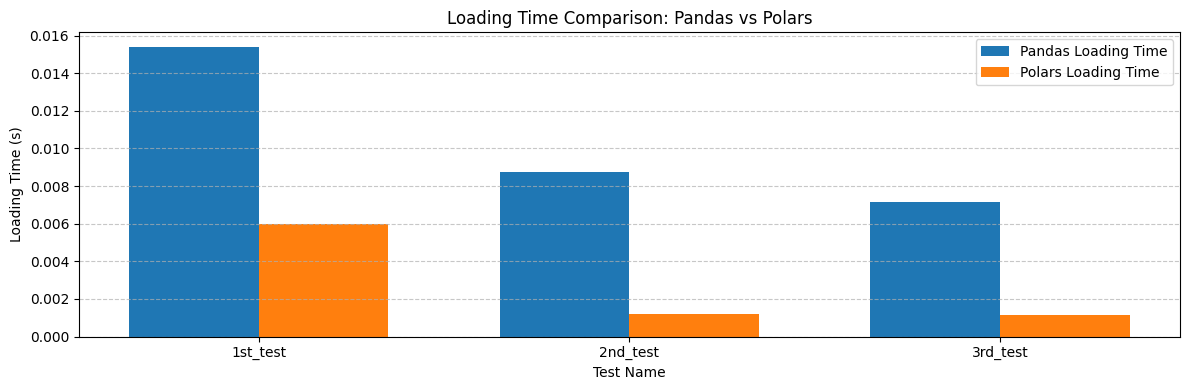

In [12]:
x = np.arange(len(loading_times_df['test_name']))
width = 0.35

plt.figure(figsize=(12, 4))
plt.bar(x - width/2, loading_times_df['pandas_loading_time'], width, label='Pandas Loading Time')
plt.bar(x + width/2, loading_times_df['polars_loading_time'], width, label='Polars Loading Time')

plt.xlabel('Test Name')
plt.ylabel('Loading Time (s)')
plt.title('Loading Time Comparison: Pandas vs Polars')
plt.xticks(x, loading_times_df['test_name'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
pandas_average_loading_time = float(loading_times_df['pandas_loading_time'].mean())
print(f'Pandas Average Loading Time: {pandas_average_loading_time:.6} seconds')

polars_average_loading_time = float(loading_times_df['polars_loading_time'].mean())
print(f'Polars Average Loading Time: {polars_average_loading_time:.6} seconds')

Pandas Average Loading Time: 0.0104437 seconds
Polars Average Loading Time: 0.00278367 seconds


In [14]:
pandas_average_loading_time_for_all_files = number_of_files * pandas_average_loading_time
print(f'Pandas Average Loading Time for all files: {pandas_average_loading_time_for_all_files:.2f} seconds')

polars_average_loading_time_for_all_files = number_of_files * polars_average_loading_time
print(f'Polars Average Loading Time for all files: {polars_average_loading_time_for_all_files:.2f} seconds')

Pandas Average Loading Time for all files: 39.27 seconds
Polars Average Loading Time for all files: 10.47 seconds


In [15]:
ratio_pandas_vs_polars = float((loading_times_df['pandas_loading_time'] / loading_times_df['polars_loading_time']).mean())
print(f'Polars loads data {ratio_pandas_vs_polars:.2f} times faster than Pandas on average.')

Polars loads data 5.37 times faster than Pandas on average.


## Result validation
Let's check that the obtained results for Pandas and Polars are the same:

In [16]:
for test_name in pandas_df_dict.keys():
    logger.info(f'Test Name: {test_name}')
    pandas_df = pandas_df_dict[test_name]
    polars_df = polars_df_dict[test_name]
    print('Pandas dataframe description:')
    display(pandas_df.describe())
    print('Polars dataframe description:')
    display(polars_df.describe())

2026-01-03 16:25:01.552 | INFO     | __main__:<module>:2 - Test Name: 1st_test


Pandas dataframe description:


,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,measurement_time_in_seconds
count,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000
mean,-0.117869,-0.117813,-0.118122,-0.118088,-0.114136,-0.114551,-0.114537,-0.111024,0.511975
std,0.099014,0.089247,0.091360,0.076483,0.114354,0.118455,0.074492,0.080365,0.295611
min,-0.708000,-0.569000,-0.750000,-0.547000,-0.784000,-0.789000,-0.432000,-0.515000,0.000000
25%,-0.181000,-0.176000,-0.181000,-0.168000,-0.188000,-0.190000,-0.161000,-0.161000,0.255988
50%,-0.117000,-0.117000,-0.117000,-0.117000,-0.115000,-0.115000,-0.115000,-0.110000,0.511975
75%,-0.054000,-0.061000,-0.056000,-0.068000,-0.039000,-0.037000,-0.068000,-0.061000,0.767962
max,0.491000,0.579000,0.229000,0.259000,0.593000,0.469000,0.325000,0.366000,1.023950


Polars dataframe description:


statistic,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,measurement_time_in_seconds
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",20480.0,20480.0,20480.0,20480.0,20480.0,20480.0,20480.0,20480.0,20480.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.117869,-0.117813,-0.118122,-0.118088,-0.114136,-0.114551,-0.114537,-0.111024,0.511975
"""std""",0.099014,0.089247,0.09136,0.076483,0.114354,0.118455,0.074492,0.080365,0.295611
"""min""",-0.708,-0.569,-0.75,-0.547,-0.784,-0.789,-0.432,-0.515,0.0
"""25%""",-0.181,-0.176,-0.181,-0.168,-0.188,-0.19,-0.161,-0.161,0.256
"""50%""",-0.117,-0.117,-0.117,-0.117,-0.115,-0.115,-0.115,-0.11,0.512
"""75%""",-0.054,-0.061,-0.056,-0.068,-0.039,-0.037,-0.068,-0.061,0.76795
"""max""",0.491,0.579,0.229,0.259,0.593,0.469,0.325,0.366,1.02395


2026-01-03 16:25:01.593 | INFO     | __main__:<module>:2 - Test Name: 2nd_test


Pandas dataframe description:


,channel_1,channel_2,channel_3,channel_4,measurement_time_in_seconds
count,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000
mean,-0.002153,-0.001498,-0.001489,-0.002907,0.511975
std,0.075615,0.094318,0.100196,0.054808,0.295611
min,-0.500000,-0.449000,-0.569000,-0.239000,0.000000
25%,-0.051000,-0.066000,-0.063000,-0.039000,0.255988
50%,-0.002000,-0.002000,-0.002000,-0.002000,0.511975
75%,0.046000,0.061000,0.061000,0.034000,0.767962
max,0.403000,0.410000,0.774000,0.229000,1.023950


Polars dataframe description:


statistic,channel_1,channel_2,channel_3,channel_4,measurement_time_in_seconds
str,f64,f64,f64,f64,f64
"""count""",20480.0,20480.0,20480.0,20480.0,20480.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",-0.002153,-0.001498,-0.001489,-0.002907,0.511975
"""std""",0.075615,0.094318,0.100196,0.054808,0.295611
"""min""",-0.5,-0.449,-0.569,-0.239,0.0
"""25%""",-0.051,-0.066,-0.063,-0.039,0.256
"""50%""",-0.002,-0.002,-0.002,-0.002,0.512
"""75%""",0.046,0.061,0.061,0.034,0.76795
"""max""",0.403,0.41,0.774,0.229,1.02395


2026-01-03 16:25:01.611 | INFO     | __main__:<module>:2 - Test Name: 3rd_test


Pandas dataframe description:


,channel_1,channel_2,channel_3,channel_4,measurement_time_in_seconds
count,20480.000000,20480.000000,20480.000000,20480.000000,20480.000000
mean,-0.002517,-0.001575,-0.001742,-0.002836,0.511975
std,0.073897,0.082452,0.066064,0.050828,0.295611
min,-0.364000,-0.408000,-0.276000,-0.249000,0.000000
25%,-0.051000,-0.059000,-0.046000,-0.037000,0.255988
50%,-0.002000,-0.002000,-0.002000,-0.002000,0.511975
75%,0.046000,0.054000,0.044000,0.032000,0.767962
max,0.447000,0.452000,0.310000,0.220000,1.023950


Polars dataframe description:


statistic,channel_1,channel_2,channel_3,channel_4,measurement_time_in_seconds
str,f64,f64,f64,f64,f64
"""count""",20480.0,20480.0,20480.0,20480.0,20480.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",-0.002517,-0.001575,-0.001742,-0.002836,0.511975
"""std""",0.073897,0.082452,0.066064,0.050828,0.295611
"""min""",-0.364,-0.408,-0.276,-0.249,0.0
"""25%""",-0.051,-0.059,-0.046,-0.037,0.256
"""50%""",-0.002,-0.002,-0.002,-0.002,0.512
"""75%""",0.046,0.054,0.044,0.032,0.76795
"""max""",0.447,0.452,0.31,0.22,1.02395


All the parameters look the same between Pandas and Polars except the *50%* for the *measurement_time_in_seconds*, which appears to be rounded in Polars to the 3rd decimal whereas in Pandas there are more decimals.

This numerical discrepancy happens as each library uses a different method for computing the quantiles:
- Pandas defaults to `interpolation="linear"`
    - Calculation: It takes the weighted average of the two nearest points.
- Polars defaults to `interpolation="nearest"` (in older versions) or has slightly different behavior depending on the specific method used.
    - Calculation: It picks the value of the data point physically closest to that percentile.

Hence, if the interpolation parameter is changed in the Polars quantile calculation we will get the same result as in Pandas (0.511975):

In [17]:

for test_name in pandas_df_dict.keys():
    print( f'Test Name: {test_name}' )
    quantile_50 = polars_df_dict[test_name].select(pl.col("measurement_time_in_seconds").quantile(0.5, interpolation="linear"))['measurement_time_in_seconds'][0]
    print(quantile_50)

Test Name: 1st_test
0.5119750000000001
Test Name: 2nd_test
0.5119750000000001
Test Name: 3rd_test
0.5119750000000001


## Summary

As a conclusion, it is possible to use Polars instead of Pandas while obtaining the same results and getting a faster performance. Nevertheless, it is necessary to understand that there might be some little differences in the results, but they can be understood by going through each packages documentation.